Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/armanrafian/Programs/thesis/sim_pipeline/../bioreactor-technical-analysis/biota/steadyfluxes.py:713: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


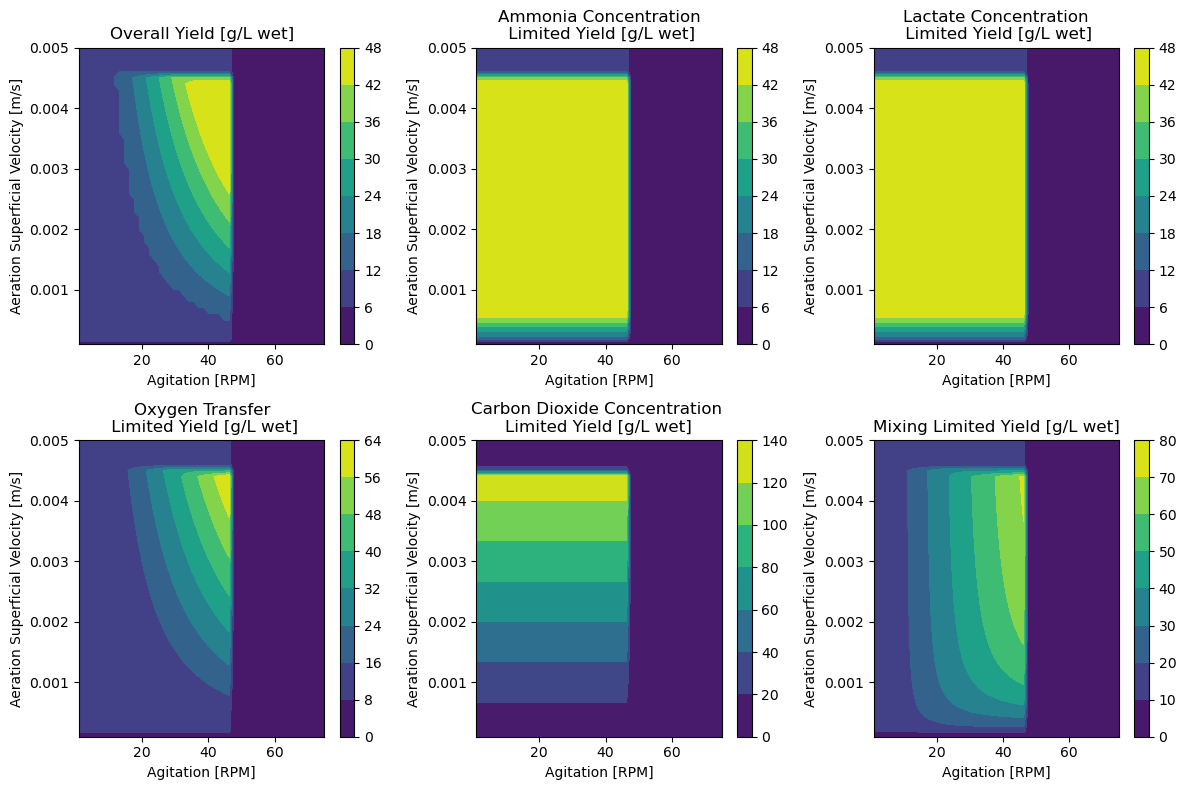

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses.
 * Running on http://10.144.36.126:5001/ (Press CTRL+C to quit)
10.144.36.126 - - [15/Mar/2024 12:55:45] "GET / HTTP/1.1" 200 -
10.144.36.126 - - [15/Mar/2024 12:55:45] "GET /static/script.js HTTP/1.1" 200 -
10.144.36.126 - - [15/Mar/2024 12:55:45] "GET /static/backgrounds/sky.jpg HTTP/1.1" 200 -
10.144.36.126 - - [15/Mar/2024 12:55:54] "GET /clear-session HTTP/1.1" 200 -
10.144.36.126 - - [15/Mar/2024 12:56:03] "GET / HTTP/1.1" 200 -
10.144.36.126 - - [15/Mar/2024 12:56:03] "GET /static/script.js HTTP/1.1" 200 -
10.144.36.126 - - [15/Mar/2024 12:56:03] "GET /static/backgrounds/sky.jpg HTTP/1.1" 200 -
Starting updateTable function
User input is: 400
Updated temp to 400
User input is: None
User input is: None
User input is: None
User input is: None
No documents found with given params. Running simulation from scratch.
locator: <matplotlib.ticker.FixedLocator object at 0x7fe73d28da00>
locator: <matplotlib.ticker.FixedLocator object at 0x7fe73ca81280>
locator:

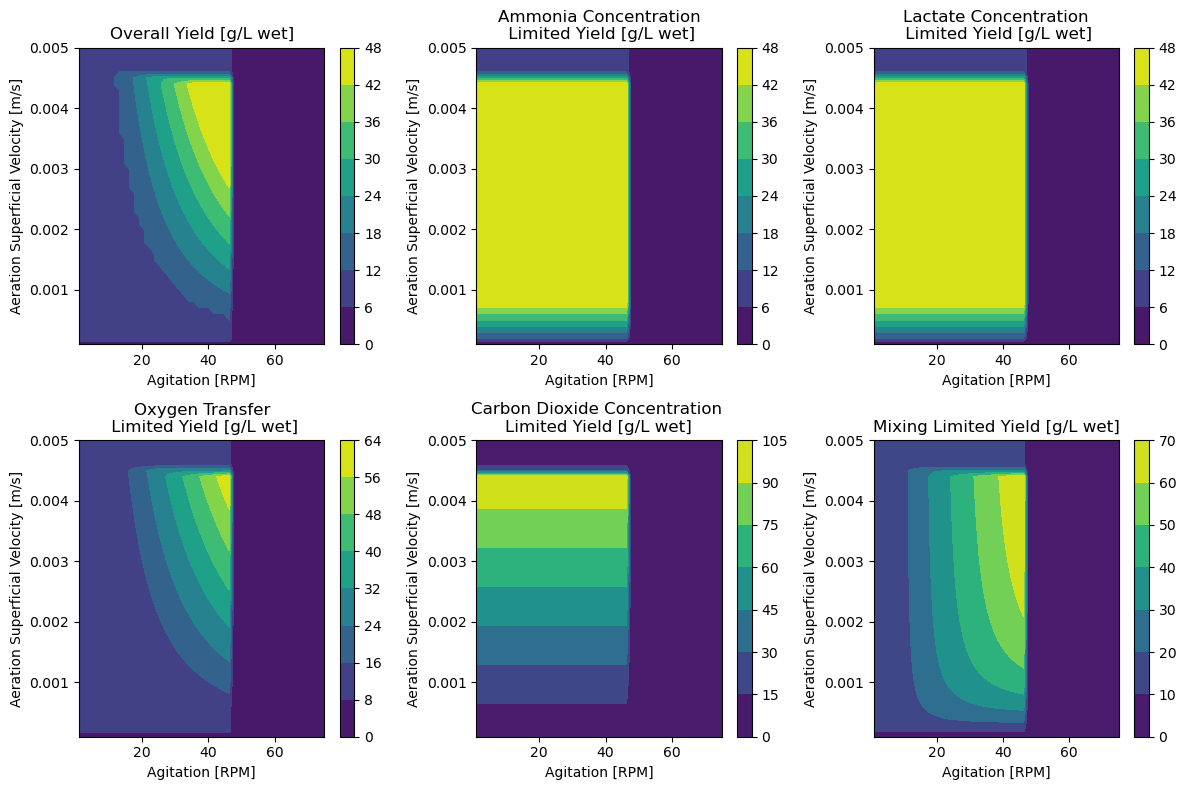

10.144.36.126 - - [15/Mar/2024 12:56:14] "POST /updateTable HTTP/1.1" 200 -


Document inserted with ID: 65f4a7de6640bebb179c2411


Starting updateTable function
User input is: 310
Updated temp to 310
User input is: None
User input is: None
User input is: None
User input is: None
Found 2 documents
10.144.36.126 - - [15/Mar/2024 12:56:41] "POST /updateTable HTTP/1.1" 200 -


In [ ]:
from flask import Flask, render_template, request, session, jsonify
from pymongo import MongoClient
import pandas as pd
import logging
from IPython.display import display, HTML
import pipeline

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# Create a StreamHandler to display log messages in the notebook
handler = logging.StreamHandler()
handler.setLevel(logging.DEBUG)
logger.addHandler(handler)

app = Flask(__name__)
app.secret_key = '29e069cadd9173cb2efac4d0ebbbada31f519cae06b1f373'

# Create a MongoDB client and connect to database
client = MongoClient("mongodb://localhost:27017/")
db = client["sims"]
collection = db["table1"]

@app.after_request
def addCacheHeaders(response):
    response.headers['Cache-Control'] = 'no-store'
    return response

# Define the 'inputs' dictionary within the session
def initSessionInputs():
    return {
        'workingVolume': 20000,
        'tankDiameter':  2.34,
        'rpm': 42.3,
        'backPressure': 1.3,
        'superficialVel': 0.004,
        'moleFracO2': 0.21,
        'moleFracCO2':  0.03,
        'initCells': 4e6,
        'temp': 310,
        'powerNumber': 5,
        'mediumDensity': 1000,
        'mediumViscosity': 9e-4,
        'vesselVolDay': 0.0,
        'perfLactateRate': 5.0,
        'perfAmmrate': 5.0,
        'growthRate': 0.029,
        'glutamineUptakeRate': 0,
        'glucoseUptakeRate': 0,
        'oxygenUptakeRate': 0.49, 
        'carbonDioxideProdRate': 0.593,
        'ammoniaProductionRate': 0.013571,
        'lactateProductionRate': 0.135707, 
        'massDensity': 1030,
        'cellRadius': 18e-6,
        'wetmass': 3000,
        'dryMassFraction': 0.3,
        'ammoniaLimit': 5,
        'lactateLimit': 50, 
        'CO2Limit': 100,
        'turbLengthLimit': 20e-6,
        'count': 50,
        'doublings': 7,
        'rpmlims': (1,75),
        'supervellims': (0.0001,0.005),
        'celldenslims': (5.9e5,6.1e5)
    }

@app.route('/updateTable', methods=['POST'])
def updateTable():
    # Retrieve session inputs
    logging.debug("Starting updateTable function")
    if 'inputs' not in session:
        session['inputs'] = initSessionInputs()

    inputs = session['inputs']

    # Get updated input params from user
    inputIDs = [('temp', 'inputTemp'), 
                   ('rpm', 'inputRPM'),
                   ('growthRate', 'inputGrowthRate'), 
                   ('mediumDensity', 'inputMediumDensity'),
                   ('doublings', 'inputDoublings')]
    for inputID in inputIDs:
        inputs = updateInput(inputs, inputID)

    # Build query using MongoDb syntax
    # Example: query['inputs.temp'] = 100
    query = {}
    for k, v in inputs.items():
        query['inputs.' + k] = v

    documentCount = collection.count_documents(query)
    if documentCount > 0:
        logging.debug("Found %s documents", documentCount)
    else:
        logging.debug("No documents found with given params. Running simulation from scratch.")
        pipeline.runSimAndInsert(inputs)
        #return jsonify({'tableHtml': ''})

    firstItem = collection.find_one(query)
    outputsData = firstItem['outputs']
    df = pd.DataFrame(outputsData.items(), columns=['Constraint', 'Maximum Yield [g/L wet]'])
    tableHtml = df.to_html(classes='table table-striped', index=False)
    return jsonify({'tableHtml': tableHtml})

def updateInput(inputs, inputID):
    name = inputID[0]
    _id = inputID[1]
    userInput = request.form.get(_id)
    logging.debug("User input is: %s", userInput)
    if userInput is not None:
        if userInput.isdigit():
            newValue = int(userInput)
        else:
            newValue = float(userInput)
            
        inputs[name] = newValue
        logging.debug("Updated %s to %s", name, newValue)
    
    return inputs
    
@app.route('/', methods=['GET'])
def index():
    return render_template('index.html', table='')
        
@app.route('/items')
def displayItems():
    items = collection.find()
    return render_template('items.html', items=items)

@app.route('/about')
def about():
    return render_template('about.html')

@app.route('/clear-session')
def clear_session_route():
    session.clear()
    return 'Session cleared'

if __name__ == '__main__':
    app.run(host="0.0.0.0", port=5001, debug=False)